# Imports

In [2]:
import importlib

import scipy.io as sio
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_classif, chi2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve

import warnings

In [3]:
LABEL = 'label'
PREDICTION = 'prediction'
POSITIVE_PROBABILITY = 'positive_probability'

In [4]:
SEED = 1

In [5]:
warnings.filterwarnings('ignore')

# Loading the dataset

In [6]:
mat = sio.loadmat('AP_Breast_Colon.mat')

breast_colon_df = pd.DataFrame(np.hstack((mat['X'], mat['Y'])))
breast_colon_df.columns = [str(col) for col in breast_colon_df.columns]
breast_colon_df.rename(columns={'10936': LABEL}, inplace=True)

In [7]:
original_breast_colon_df = breast_colon_df

In [8]:
ORIGINAL_FEATURE_COLUMNS = [column for column in original_breast_colon_df if column != LABEL]

In [9]:
breast_colon_df

0       1       2       3       4       5      6       7       8  \
0    137984.0  2503.7   669.0   509.8   559.1   664.5  277.2  1309.8  1104.0   
1    117695.0  4444.8   944.0   303.1   166.1   272.2  453.6  1217.5  3629.5   
2    231892.0  3145.0   506.9  2469.1   405.5   813.1  149.6   468.9  1216.6   
3     53187.0  2601.9   766.8   659.5   639.3   647.0  250.2   682.8  2737.6   
4     46890.0  5536.9   661.9   836.6   621.2   955.7   72.9  1346.3  1316.7   
..        ...     ...     ...     ...     ...     ...    ...     ...     ...   
625   46832.0  2178.7   555.8   471.5     6.1  1343.1   95.0   353.0  1006.0   
626  102549.0  3142.5   662.5   406.6  1316.7   781.9  230.3   434.3   783.6   
627  138032.0  3977.9  1141.0   426.0    72.7  1605.0  371.9  2236.1  2148.8   
628  203705.0   752.4   597.8   196.0   345.5   708.6  146.1   583.8  1012.8   
629  179928.0  3633.6   668.8   275.2   722.9  1592.1  247.2  1730.7  1102.6   

          9  ...    10927    10928    10929    10930     10931     10932  \
0     135.1  ...  10018.5  10653.2  54989.5  46099.9  125395.9   99534.9   
1      61.6  ...  14223.1  13735.3  65269.9  62083.9  190438.7  146509.2   
2     192.3  ...   3020.7   2715.2  39932.9  35988.5   95011.2   76480.6   
3     241.8  ...   8265.9   7018.1  30975.2  28494.1   95891.0   73144.1   
4     128.5  ...   1949.7   1686.9   9589.0   8511.2   26369.1   18663.3   
..      ...  ...      ...      ...      ...      ...       ...       ...   
625   145.0  ...   2079.3   2168.2  12330.3  10294.8   34148.0   27073.9   
626   220.1  ...   9847.4   9808.7  44860.5  39851.0  149516.6  105013.7   
627  1377.2  ...  12592.6  12779.8  71378.7  60402.9  177803.8  134430.5   
628   103.7  ...   5818.1   5230.5  31208.6  29470.2   87586.7   66951.2   
629   885.2  ...   2116.0   2133.0  33620.0  28979.8   93839.8   73388.7   

      10933   10934   10935  label  
0    3588.1  1404.8  2013.6    0.0  
1    3597.7  1608.6  2259.6    0.0  
2    1502.6   430.8  1020.9    0.0  
3    1293.9   601.0   887.4    0.0  
4     249.9     9.2   101.8    0.0  
..      ...     ...     ...    ...  
625    12.8    11.5     5.7    1.0  
626  4123.3  1711.6  2438.6    1.0  
627  2064.0   102.6   495.4    1.0  
628  4545.4  1821.1  2999.7    1.0  
629  1779.2   542.0  1088.3    1.0  

[630 rows x 10937 columns]

# Data preprocessing

#### Missing/invalid values

In [16]:
nan_counts = breast_colon_df.isna().sum().sort_values(ascending=False)
nan_counts = nan_counts.reset_index(drop=True)
top_10_nans = nan_counts.head(10)
top_10_nans

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [17]:
zero_counts = (breast_colon_df == 0).sum().sort_values(ascending=False)
zero_counts = zero_counts.reset_index(drop=True)
top_10_zeroes = zero_counts.head(10)
top_10_zeroes

0    344
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
dtype: int64

We can see that there are no missing values /  zeroes (apart from the label column)

In [18]:
negative_values = (breast_colon_df < 0).any().any()

if negative_values:
    print("There are negative values in the DataFrame.")
else:
    print("There are no negative values in the DataFrame.")

There are no negative values in the DataFrame.


#### Normalization

Its easy to see that features arent in the same scale, and since I want to use neural networks later, I rather normalize it.
I wont necessary need it for the model task (since most tree based models can deal with data that isnt normalized) but I will need it for the feature selection task.

I rather use normalization since I dont know what is the distribution of each feature, and since there are alot of em, I cant check it manually.

I will use min-max normalization, since I want to work in the range of 0-1, and at this stage, im not sure i will need something "special" and complex for the normalization method.

In [22]:
min_max_scaler = MinMaxScaler()
columns_to_scale = ORIGINAL_FEATURE_COLUMNS
breast_colon_df[columns_to_scale] = min_max_scaler.fit_transform(breast_colon_df[columns_to_scale])

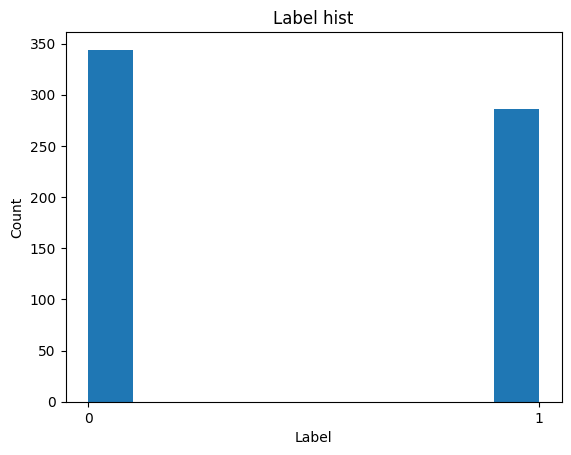

In [33]:
breast_colon_df[LABEL].hist()
plt.xticks(np.arange(0, 2))
plt.title('Label hist')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(False)
pass

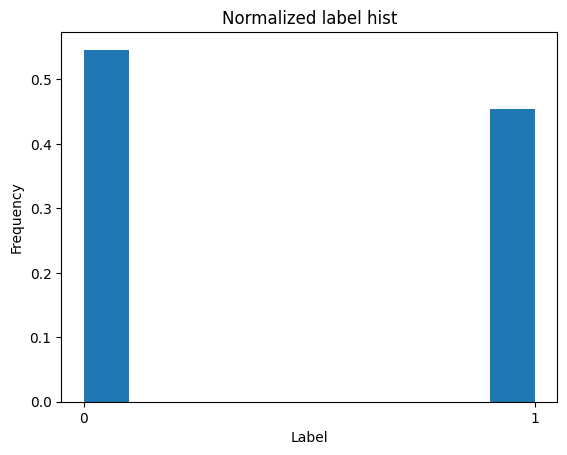

In [44]:
weights = np.ones_like(breast_colon_df[LABEL])/float(len(breast_colon_df[LABEL]))
plt.hist(breast_colon_df[LABEL], weights=weights)
plt.xticks(np.arange(0, 2))
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Normalized label hist')
pass

We can see that for the most part the data is ballanced.

Its important so that there will be no bias and overfitting on the majority class, and will help us with fair evaluation without using any complex strategies.

# Feature selection

#### Data split

In [156]:
train_features, test_features, train_labels, test_labels = train_test_split(breast_colon_df[ORIGINAL_FEATURE_COLUMNS], breast_colon_df[LABEL], test_size=0.3, random_state=SEED)

#### univariteFS

Explanation:  

Univariate feature selection (UniVariteFS) is a technique used in machine learning and statistics to select the best features (variables) for modeling based on their individual relationship with the target variable.

Multiple methods can be chosen, such as f_classif (our case), or chi2 for example.

I used f_classfic because the features are continuous.

First, I want to get the scores of the features to see their importance, so I can know how many features to pick.  
One method is the do a "כלל אצבע" (for example 10% of the features or w.e) but since I have no domain knowledge, I rather analyze the data.

In [139]:
k_best_selector = SelectKBest(f_classif, k=len(ORIGINAL_FEATURE_COLUMNS))
k_best_selector.fit(train_features[ORIGINAL_FEATURE_COLUMNS], train_labels)
selected_indices = k_best_selector.get_support(indices=True)

In [140]:
feature_scores = pd.DataFrame({'Feature': ORIGINAL_FEATURE_COLUMNS, 'Score': k_best_selector.scores_})

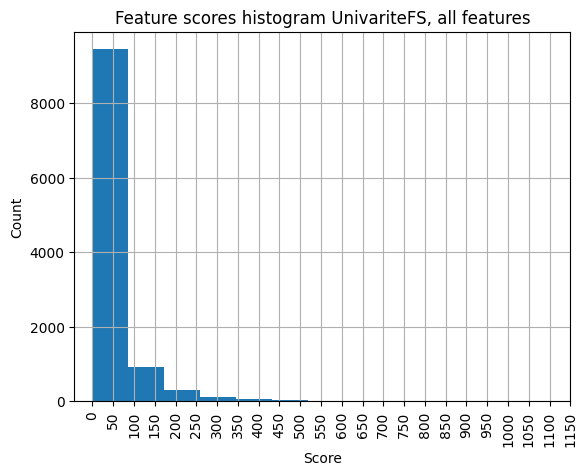

In [141]:
feature_scores.hist()
plt.title('Feature scores histogram UnivariteFS, all features')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(np.arange(0, 1200, 50), rotation=90)
pass

We can see that the feature scores have a paretro distribution

In [142]:
for maximum_score in [10, 100, 200, 300, 500]:
    low_score_features = feature_scores[feature_scores['Score'] < maximum_score]
    num_low_score_features = low_score_features.shape[0]
    print(f'Features with score lower than {maximum_score}: {num_low_score_features} out of {len(ORIGINAL_FEATURE_COLUMNS)} features, which is {round(num_low_score_features  / len(ORIGINAL_FEATURE_COLUMNS), 3) * 100}%')

Features with score lower than 10: 4207 out of 10936 features, which is 38.5%
Features with score lower than 100: 9669 out of 10936 features, which is 88.4%
Features with score lower than 200: 10491 out of 10936 features, which is 95.89999999999999%
Features with score lower than 300: 10743 out of 10936 features, which is 98.2%
Features with score lower than 500: 10892 out of 10936 features, which is 99.6%


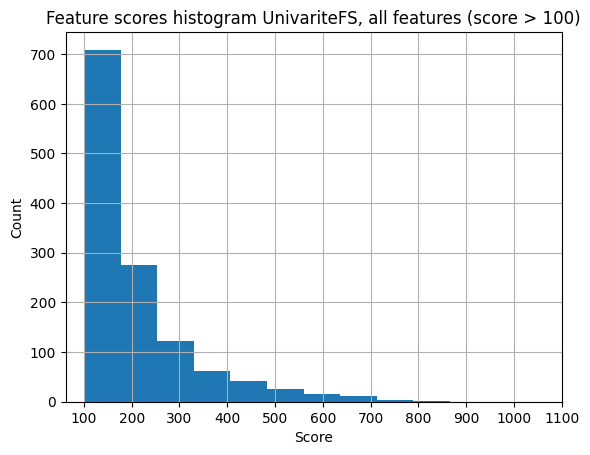

In [143]:
feature_scores[feature_scores['Score'] > 100].hist()
plt.xticks(np.arange(100, 1200, 100))
plt.title('Feature scores histogram UnivariteFS, all features (score > 100)')
plt.xlabel('Score')
plt.ylabel('Count')
pass

In [217]:
top_10_features = feature_scores.sort_values(by='Score', ascending=False)
top_10_features = top_10_features.reset_index(drop=True)
top_10_features = top_10_features.head(10)

print("Top 10 features with highest scores: (highest correlation to label)")
display(top_10_features)

Top 10 features with highest scores: (highest correlation to label)


Feature       Score
9861     9861  866.307119
2532     2532  813.718357
5215     5215  778.807068
3031     3031  741.974383
4158     4158  736.071255
7448     7448  703.929038
4159     4159  688.128268
4451     4451  674.032442
7813     7813  673.021768
10090   10090  672.710561

We can see that only 7% of the features have a score higher than 200, the number itself doesnt mean much on its own, but we can conclude that those features-  
have a stronger connection with the label.  
So I decided to pick the top 7% (774) features.

In [145]:
univariteFS_features =  list(feature_scores.sort_values(by='Score', ascending=False).head(774)['Feature'])

#### Unsupervised Feature Selection Algorithm (UFS)

Explanation:

UFS is a feature selection algorithm and has 2 parts:
1. Scorer
2. Selector

The Scorer gives a score to all the features using NN,  and the Selector adopts a dependent sub-NN to locally evaluate the representation abilities for selecting features.

It has several hypter parameters, such as the epochs number, batch size, loss values and learning rate.

In [18]:
import UFS
importlib.reload(UFS)
from UFS import alg as ufs

Note: I will take the hyper parameters from the study, as suggested by Itamar

p_learning_rate= 1E-3  
p_loss_weight_1=1   
p_loss_weight_2=2  

Altough I didnt quite understand why l1_lambda is missing

In [22]:
hyper_parameters = {
    'epochs_number': [100],
    'batch_size_value': [64]
}

tempdf_hyperparamter = pd.DataFrame(hyper_parameters)

In [23]:
breast_colon_df_as_dict = {'X': train_features[ORIGINAL_FEATURE_COLUMNS].values, 'Y': train_labels.values.reshape(-1, 1).astype(int)}

sio.savemat('train_breast_colon.mat', breast_colon_df_as_dict)

To make it "fair", I will take the top 774 features in UFS aswell

In [24]:
ufs_results = ufs(k=774, data_path='train_breast_colon.mat', tempdf_hyperparamter=tempdf_hyperparamter)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - loss: 0.4358 - val_loss: 0.1534
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.1760 - val_loss: 0.0945
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.1036 - val_loss: 0.0835
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - loss: 0.0858 - val_loss: 0.1242
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 0.1109 - val_loss: 0.2329
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - loss: 0.1659 - val_loss: 0.0646
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - loss: 0.0821 - val_loss: 0.0902
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - loss: 0.0908 - val_loss: 0.0919
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - loss: 0.0815 - val_loss: 0.0895
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step - loss: 0.0816 - val_loss: 0.0560
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - loss: 0.0603 - val_loss: 0.0685
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - loss: 0.0

In [25]:
ufs_features = [str(feature) for feature in ufs_results[3]]

#### Comparison

In [26]:
univariteFS_features
ufs_features
pass

In [27]:
difference = [feature for feature in univariteFS_features if feature not in ufs_features]

In [28]:
print(f'Amount of features in ufs that arent in univariteFS: {len(difference)}')

Amount of features in ufs that arent in univariteFS: 730


We can see that the difference is huge, and there are only 44 features that are in both groups.

***Note: From what I know, nn based models require higher amounts of data, so the size of the data might not be sufficient to get the best out of UFC.

# Model development

In [157]:
def predict(model, dataset):
    predictions = model.predict(dataset)
    positive_class_probabilities = model.predict_proba(dataset)[:, 1]
    
    dataset[PREDICTION] = predictions
    dataset[POSITIVE_PROBABILITY] = positive_class_probabilities

    return dataset

In [158]:
def get_precision_recall_threshold(test_predictions, train_predictions):
    test_precision, test_recall, test_thresholds = precision_recall_curve(test_labels, test_predictions[POSITIVE_PROBABILITY])
    test_precision = test_precision[:-1]
    test_recall = test_recall[:-1]

    train_precision, train_recall, train_thresholds = precision_recall_curve(train_labels, train_predictions[POSITIVE_PROBABILITY])
    train_precision = train_precision[:-1]
    train_recall = train_recall[:-1]

    return test_precision, test_recall, test_thresholds, train_precision, train_recall, train_thresholds

#### RF Model with the original features

In [159]:
og_rf_classifier = RandomForestClassifier(n_estimators=50, random_state=SEED)
og_rf_classifier.fit(train_features, train_labels)

og_train_predictions = predict(og_rf_classifier, train_features)
og_test_predictions = predict(og_rf_classifier, test_features)

In [160]:
og_accuracy = round(accuracy_score(test_labels, og_test_predictions[PREDICTION]), 3)
print("Original features accuracy:", og_accuracy)

og_roc_auc = round(roc_auc_score(test_labels, og_test_predictions[PREDICTION]), 3)
print("Original features ROC-AUC score:", og_roc_auc)

Original features accuracy: 0.942
Original features ROC-AUC score: 0.939


#### RF Model with univariteFS top k features

In [161]:
univariteFS_train_features = train_features[univariteFS_features]
univariteFS_test_features = test_features[univariteFS_features]

univariteFS_rf_classifier = RandomForestClassifier(n_estimators=50, random_state=SEED)
univariteFS_rf_classifier.fit(univariteFS_train_features, train_labels)

univariteFS_train_predictions = predict(univariteFS_rf_classifier, univariteFS_train_features)
univariteFS_test_predictions = predict(univariteFS_rf_classifier, univariteFS_test_features)

In [162]:
univariteFS_accuracy = round(accuracy_score(test_labels, univariteFS_test_predictions[PREDICTION]), 3)
print("univariteFS features accuracy:", univariteFS_accuracy)

univariteFS_roc_auc = round(roc_auc_score(test_labels, univariteFS_test_predictions[PREDICTION]), 3)
print("univariteFS features ROC-AUC score:", univariteFS_roc_auc)

univariteFS features accuracy: 0.952
univariteFS features ROC-AUC score: 0.951


We can see a slightly better performance in the  univariteFS model after the feature selection process (via accuracy/roc auc), even tho we have way only 7% of the features

#### RF Model with UFS top k features

In [163]:
ufs_train_features = train_features[ufs_features]
ufs_test_features = test_features[ufs_features]

ufs_rf_classifier = RandomForestClassifier(n_estimators=50, random_state=SEED)
ufs_rf_classifier.fit(ufs_train_features, train_labels)

ufs_train_predictions = predict(ufs_rf_classifier, ufs_train_features)
ufs_test_predictions = predict(ufs_rf_classifier, ufs_test_features)

In [164]:
ufs_accuracy = round(accuracy_score(test_labels, ufs_test_predictions[PREDICTION]), 3)
print("UFS features accuracy:", ufs_accuracy)

ufs_roc_auc = round(roc_auc_score(test_labels, ufs_test_predictions[PREDICTION]), 3)
print("UFS features ROC-AUC score:", ufs_roc_auc)

UFS features accuracy: 0.947
UFS features ROC-AUC score: 0.945


#### Accuracy and ROC-AUC summary

In [165]:
data = [
    ['original_features', og_accuracy, og_roc_auc],
    ['univariteFS', univariteFS_accuracy, univariteFS_roc_auc],
    ['UFS', ufs_accuracy, ufs_roc_auc]
]
columns = ['model_type', 'accuracy', 'roc_auc']
df = pd.DataFrame(data, columns=columns)

display(df)

model_type  accuracy  roc_auc
0  original_features     0.942    0.939
1        univariteFS     0.952    0.951
2                UFS     0.947    0.945

Slight win for univariteFS

Note: roc_auc and accuracy have close values, because roc auc measures tp vs fp while accuracy measures correct classifications vs incorrect

And since in our case the labels are ballanced, and the model is very good at distinguishing between classes, we get a very high percentage of tp and tn, and a very low amount of fp and fn,

so the model has a a very high roc auc (tp/fp) and very high accuracy (correct vs incorrect), both values are close to 1.

#### Precision-Recall

In [166]:
og_test_precision, og_test_recall, og_test_threshold, og_train_precision, og_train_recall, og_train_threshold = get_precision_recall_threshold(og_test_predictions, og_train_predictions)
univariteFS_test_precision, univariteFS_test_recall, univariteFS_test_threshold, univariteFS_train_precision, univariteFS_train_recall, univariteFS_train_threshold = get_precision_recall_threshold(univariteFS_test_predictions, univariteFS_train_predictions)
ufs_test_precision, ufs_test_recall, ufs_test_threshold, ufs_train_precision, ufs_train_recall, ufs_train_threshold = get_precision_recall_threshold(ufs_test_predictions, ufs_train_predictions)

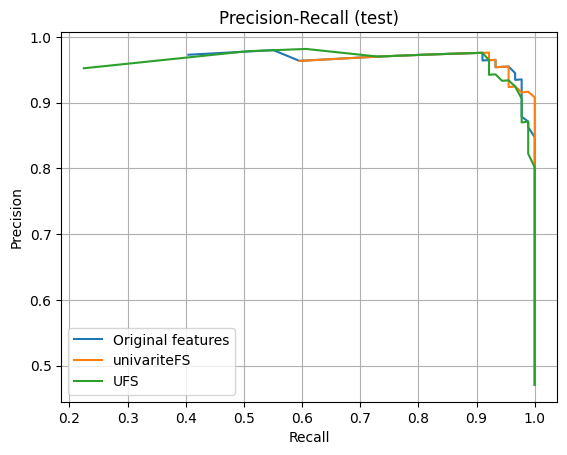

In [167]:
plt.plot(og_test_recall, og_test_precision, label='Original features')
plt.plot(univariteFS_test_recall, univariteFS_test_precision, label='univariteFS')
plt.plot(ufs_test_recall, ufs_test_precision, label='UFS')
plt.grid(True)
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (test)')
pass

Conclusions:  
1. Performances are generally similar, although if we compare univariteFS and UFS, univariteFS is the clear winner.
2. univariteFS gets us the best precision for maximum recall.
3. Depends on the required recall/precision, a different FS algo might be the best.
4. If we only care about precision, UFS can provide the best (but with rather low recall [0.6])

#### Overfit check

In [168]:
original_features = ('Original_features', og_test_precision, og_test_recall, og_train_precision, og_train_recall)
univariteFS = ('univariteFS', univariteFS_test_precision, univariteFS_test_recall, univariteFS_train_precision, univariteFS_train_recall)
ufs = ('UFS', ufs_test_precision, ufs_test_recall, ufs_train_precision, ufs_train_recall)

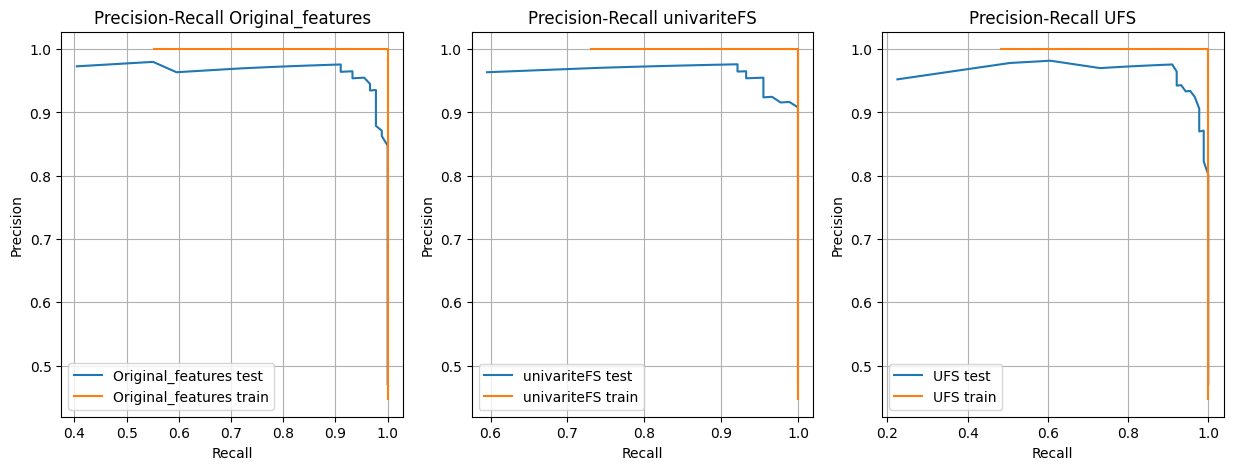

In [169]:
name_idx = 0
test_precision_idx = 1
test_recall_idx = 2
train_precision_idx = 3
train_recall_idx = 4

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, algo in enumerate([original_features, univariteFS, ufs]):
    ax[i].plot(algo[test_recall_idx], algo[test_precision_idx], label=f'{algo[name_idx]} test')
    ax[i].plot(algo[train_recall_idx], algo[train_precision_idx], label=f'{algo[name_idx]} train')
    ax[i].grid(True)
    ax[i].set_xlabel('Recall')
    ax[i].set_ylabel('Precision')
    ax[i].set_title(f'Precision-Recall {algo[name_idx]}')
    ax[i].legend()

All models have a slight overfit, maybe its worth lowering the number of estimators in the rf model

Conclusions:  
1. We managed to get better results with the models that used feature selection.
2. We managed to get slightly less overfit with the models that used feature selection.
3. Using only a fraction of the features for better results, shows us that there is a lot of noise in the data.
4. We can pinpoint which features give us the best signal.

# Feature Importance

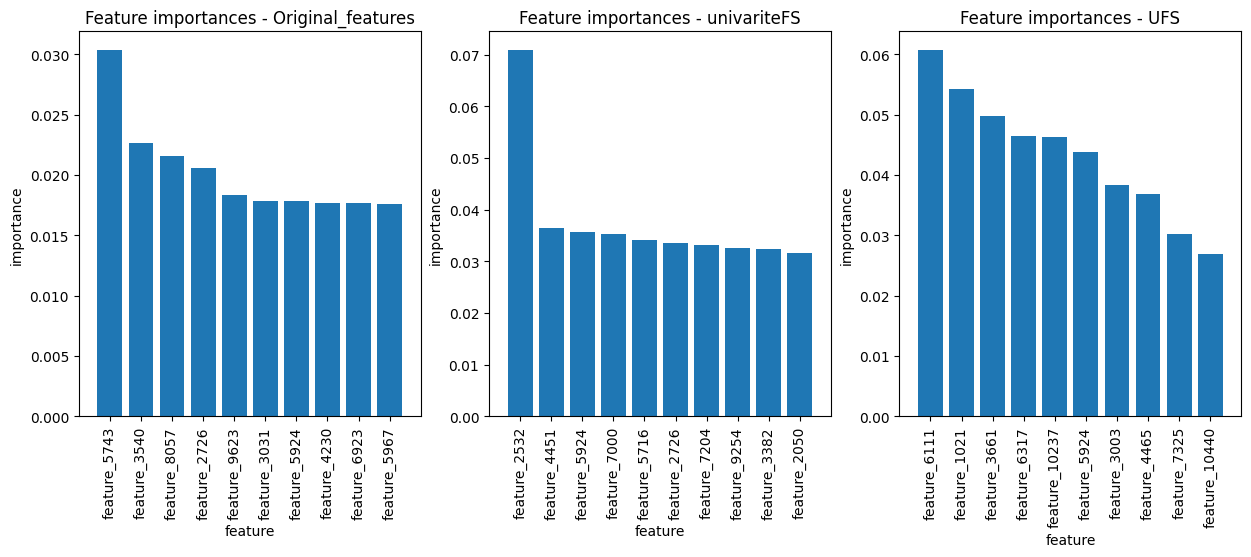

In [170]:
name_idx = 0
train_features_index = 1
classifier_index = 2

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

original_features = ('Original_features', train_features, og_rf_classifier)
univariteFS = ('univariteFS', univariteFS_train_features, univariteFS_rf_classifier)
ufs = ('UFS', ufs_train_features, ufs_rf_classifier)

for i, algo in enumerate([original_features, univariteFS, ufs]):
    feature_names = [f'feature_{i}' for i in list(algo[train_features_index].columns)]
    importances = algo[classifier_index].feature_importances_
    
    indices = np.argsort(importances)[::-1][:10]
    ax[i].set_title(f"Feature importances - {algo[name_idx]}")
    ax[i].bar(range(10), importances[indices], align="center")
    ax[i].set_xticks(range(10), [feature_names[i] for i in indices], rotation=90)
    ax[i].set_xlim([-1, 10])
    ax[i].set_xlabel('feature')
    ax[i].set_ylabel('importance')

We can see that both original features model and univariteFS have 1 "best" feature, while UFS has slighly better distribution.

In [177]:
def get_algo_top_k_features(model, train, k):
    feature_names = [f'feature_{i}' for i in list(train.columns)]
    importances = model.feature_importances_
        
    indices = np.argsort(importances)[::-1][:10]

    return [feature_names[i] for i in indices]

In [180]:
original_features_top_10 = get_algo_top_k_features(og_rf_classifier, train_features, 10)
univariteFS_features_top_10 = get_algo_top_k_features(univariteFS_rf_classifier, univariteFS_train_features, 10)
ufs_features_top_10 = get_algo_top_k_features(ufs_rf_classifier, ufs_train_features, 10)

In [185]:
overall_intersection = set(original_features_top_10) & set(univariteFS_features_top_10) & set(ufs_features_top_10)

In [196]:
print(f'Features that appear in all 3 algos top-10 features: {', '.join(intersection)}')

intersection_1_2 = set(original_features_top_10) & set(univariteFS_features_top_10)
print(f'Intersection between original_features_top_10 and univariteFS_features_top_10: {', '.join(intersection_1_2)}')

intersection_1_3 = set(original_features_top_10) & set(ufs_features_top_10)
print(f'Intersection between original_features_top_10 and ufs_features_top_10: {', '.join(intersection_1_3)}')

intersection_2_3 = set(univariteFS_features_top_10) & set(ufs_features_top_10)
print(f'Intersection between univariteFS_features_top_10 and ufs_features_top_10: {', '.join(intersection_2_3)}')

Features that appear in all 3 algos top-10 features: feature_5924
Intersection between original_features_top_10 and univariteFS_features_top_10: feature_5924, feature_2726
Intersection between original_features_top_10 and ufs_features_top_10: feature_5924
Intersection between univariteFS_features_top_10 and ufs_features_top_10: feature_5924


We can see that gene number 5924 is key in all 3 models  
Also, gene 2726 appeares in the top 10 of 2/3 models

# Connection between FS algorithms outputs

Since univerateFS is deterministic, I will check it for ufs.  
I will do 5 runs.

In [22]:
NUMBER_OF_EXPERIMENTS = 5 

In [23]:
hyper_parameters = {
    'epochs_number': [25],
    'batch_size_value': [64]
}

tempdf_hyperparamter = pd.DataFrame(hyper_parameters)

In [24]:
results = []

for i in range(NUMBER_OF_EXPERIMENTS):
    ufs_results = ufs(k=774, data_path='train_breast_colon.mat', tempdf_hyperparamter=tempdf_hyperparamter, seed=i)
    results.append([str(feature) for feature in ufs_results[3]])

Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - loss: 0.4358 - val_loss: 0.1534
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.1760 - val_loss: 0.0945
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - loss: 0.1036 - val_loss: 0.0835
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - loss: 0.0858 - val_loss: 0.1242
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 0.1109 - val_loss: 0.2329
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - loss: 0.1659 - val_loss: 0.0646
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0821 - val_loss: 0.0902
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - loss: 0.0908 - val_loss: 0.0919
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - loss: 0.0815 - val_loss: 0.0895
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0816 - val_loss: 0.0560
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0603 - val_loss: 0.0685
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - loss: 0.0587 - val_lo

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - loss: 0.4334 - val_loss: 0.1773
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.1861 - val_loss: 0.1032
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - loss: 0.1097 - val_loss: 0.1152
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - loss: 0.1039 - val_loss: 0.1362
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - loss: 0.1256 - val_loss: 0.1257
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.1145 - val_loss: 0.1630
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.1330 - val_loss: 0.1249
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.1327 - val_loss: 0.0918
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - loss: 0.0894 - val_loss: 0.0709
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 0.0789 - val_loss: 0.0585
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 0.0586 - val_loss: 0.0534
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.0518 - val_lo

Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - loss: 0.4325 - val_loss: 0.1647
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.1838 - val_loss: 0.1010
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.1101 - val_loss: 0.0984
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0967 - val_loss: 0.1058
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.1083 - val_loss: 0.1348
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - loss: 0.1207 - val_loss: 0.1296
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.1262 - val_loss: 0.0894
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - loss: 0.1030 - val_loss: 0.0632
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - loss: 0.0674 - val_loss: 0.0605
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - loss: 0.0587 - val_loss: 0.0541
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - loss: 0.0507 - val_loss: 0.0488
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - loss: 0.0474 - val_lo

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - loss: 0.4255 - val_loss: 0.1603
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - loss: 0.1787 - val_loss: 0.0929
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 0.0995 - val_loss: 0.0729
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - loss: 0.0713 - val_loss: 0.0875
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - loss: 0.0810 - val_loss: 0.1071
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0924 - val_loss: 0.0940
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - loss: 0.0930 - val_loss: 0.1173
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - loss: 0.0967 - val_loss: 0.1031
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.0896 - val_loss: 0.0805
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - loss: 0.0902 - val_loss: 0.1287
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 0.1002 - val_loss: 0.1808
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - loss: 0.1270 - val_lo

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ autoencoder_input             │ (None, 10936)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ feature_selection             │ (None, 10936)             │          10,936 │ autoencoder_input[0][0],   │
│ (Feature_Select_Layer)        │                           │                 │ autoencoder_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_hidden_layer      │ (None, 774)               │       8,465,238 │ feature_selection[0][0],   │
│ (Dense)                       │                           │                 │ feature_selection[1][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ autoencoder_output (Dense)    │ (None, 10936)             │       8,475,400 │ autoencoder_hidden_layer[… │
│                               │                           │                 │ autoencoder_hidden_layer[… │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,951,574 (64.67 MB)

 Trainable params: 16,951,574 (64.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - loss: 0.4327 - val_loss: 0.1561
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - loss: 0.1759 - val_loss: 0.1018
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.1020 - val_loss: 0.0676
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - loss: 0.0709 - val_loss: 0.0758
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - loss: 0.0770 - val_loss: 0.1171
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - loss: 0.1019 - val_loss: 0.2156
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - loss: 0.1504 - val_loss: 0.0785
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - loss: 0.1087 - val_loss: 0.1164
Epoch 9/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - loss: 0.1016 - val_loss: 0.0922
Epoch 10/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.0951 - val_loss: 0.0690
Epoch 11/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - loss: 0.0708 - val_loss: 0.0653
Epoch 12/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - loss: 0.0625 - val_lo

In [26]:
sets = [set(lst) for lst in results]

common_elements = set.intersection(*sets)
print(f"Number of common elements in all feature groups: {len(common_elements)}")

for i, s in enumerate(sets):
    unique_elements = s - set.union(*(sets[:i] + sets[i+1:]))
    print(f"Number of unique elements in list {i+1}: {len(unique_elements)}")

Number of common elements in all feature groups: 22
Number of unique elements in list 1: 468
Number of unique elements in list 2: 479
Number of unique elements in list 3: 492
Number of unique elements in list 4: 454
Number of unique elements in list 5: 472


In [29]:
print(f'Features that appear in all sets: {", ".join(common_elements)}')

Features that appear in all sets: 2467, 9935, 10598, 7407, 6030, 3184, 10143, 3363, 4879, 6306, 4947, 8215, 280, 3605, 10494, 2860, 5950, 10068, 4907, 3366, 4563, 7455


We can see that we have around 300 features that appear in more than 1 result, and 22 that appear in all of them.

In [3]:
!pip3 freeze > requirements.txt